<a href="https://colab.research.google.com/github/JohannesBauer97/dog-classification/blob/main/dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Classification Network
Train a model which can classify different dog breeds.

Using the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)

# Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import xml.etree.ElementTree as et
import os
from PIL import Image

print("Tensorflow Version:",tf.__version__)
!nvidia-smi -L

Tensorflow Version: 2.3.0
GPU 0: Tesla T4 (UUID: GPU-0bb40a5a-55bb-9a6e-1ccd-774e8818f6df)


# Download Dataset

In [ ]:
image_dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
images_dir = tf.keras.utils.get_file("Images", image_dataset_url, untar=True)
annotations_dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
annotations_dir = tf.keras.utils.get_file("Annotation", annotations_dataset_url, untar=True)

print("Images:", images_dir, "Annotation:", annotations_dir)

21856256/21852160 [==============================] - 2s 0us/step
Images: /root/.keras/datasets/Images Annotation: /root/.keras/datasets/Annotation


# Crop Images
Use the annotations to crop the images that only the dog is visible.

In [ ]:
target_dir = "Cropped"
os.mkdir(target_dir)

breed_list = os.listdir(images_dir)
counter = 1
counter_max = len(breed_list)

for breed in breed_list:
    os.mkdir(target_dir + "/" + breed)
    print("Created ({}/{}): {}/{}".format(counter, counter_max, target_dir, breed))
    counter += 1
    for file in os.listdir(annotations_dir + "/" + breed):
        img = Image.open(images_dir + "/" + breed + "/" + file + ".jpg")
        xml_tree = et.parse(annotations_dir + "/" + breed + "/" + file)
        x_min = int(xml_tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        x_max = int(xml_tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        y_min = int(xml_tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        y_max = int(xml_tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((x_min, y_min, x_max, y_max))
        img = img.convert('RGB')
        # img = img.resize((299, 299))
        img.save(target_dir + "/" + breed + "/" + file + ".jpg")

#Model compiling, training and testing

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


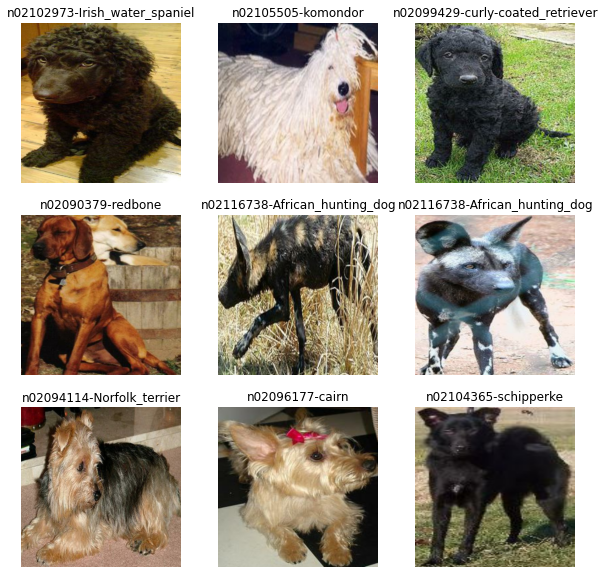

Epoch 1/15
515/515 [==============================] - 723s 1s/step - loss: 2.6895 - accuracy: 0.3085 - val_loss: 2.2904 - val_accuracy: 0.3919
Epoch 2/15
515/515 [==============================] - 723s 1s/step - loss: 1.8844 - accuracy: 0.4616 - val_loss: 1.9474 - val_accuracy: 0.4650
Epoch 3/15
515/515 [==============================] - 719s 1s/step - loss: 1.6213 - accuracy: 0.5266 - val_loss: 1.6877 - val_accuracy: 0.5204
Epoch 4/15
515/515 [==============================] - 720s 1s/step - loss: 1.4227 - accuracy: 0.5751 - val_loss: 1.5415 - val_accuracy: 0.5510
Epoch 5/15
515/515 [==============================] - 725s 1s/step - loss: 1.2971 - accuracy: 0.6127 - val_loss: 1.4403 - val_accuracy: 0.5804
Epoch 6/15
515/515 [==============================] - 721s 1s/step - loss: 1.2184 - accuracy: 0.6327 - val_loss: 1.1145 - val_accuracy: 0.6642
Epoch 7/15
515/515 [==============================] - 722s 1s/step - loss: 1.1312 - accuracy: 0.6529 - val_loss: 1.1189 - val_accuracy: 0.6703

In [ ]:
img_height = 299
img_width = 299
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=target_dir,
    validation_split=0.2,
    subset="training",
    seed=6214,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=target_dir,
    validation_split=0.2,
    subset="validation",
    seed=9423,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)


num_classes = len(class_names)
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.applications.Xception(
        include_top=False,
        # classes=num_classes,
        pooling="avg"
    ),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(120)
])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

epochs = 15
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    # callbacks=early_stop
)

model.summary()
model.save("model")

#
# Visualize Training
#

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#
# Test against image
#

test_url = "https://www.telegraph.co.uk/content/dam/science/2017/09/10/TELEMMGLPICT000107300056_trans_NvBQzQNjv4BqyuLFFzXshuGqnr8zPdDWXiTUh73-1IAIBaONvUINpkg.jpeg"
test_path = tf.keras.utils.get_file("test", origin=test_url)

img = tf.keras.preprocessing.image.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

